# funcs n imports

In [1]:
import pyxdf
import mne
import mne_connectivity
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.signal import sosfiltfilt, butter, hilbert
from scipy import io
from scipy.stats import pearsonr
from scipy.io import loadmat
from scipy import signal
from scipy.signal import (butter,lfilter,hilbert,resample)
from scipy.stats import zscore
from pylab import *
import os as os

from pingouin import circ_corrcl

import seaborn as sns

import neurodsp
from neurodsp import spectral
from neurodsp import filt
from neurodsp import sim

import fooof
from fooof import FOOOF
from fooof import FOOOFGroup
#from fooof.plts.templates import plot_spectrum
from sklearn.decomposition import PCA

from pyentrp import entropy as ent
import antropy as ant
from antropy import lziv_complexity


c:\Users\jaket\anaconda3\envs\deco1\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
c:\Users\jaket\anaconda3\envs\deco1\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
#Load the Raw Data
data = np.load(r'C:\Users\jaket\COGS280\DataDeco\eeg.npy')

behavior = pd.read_csv(r'C:\Users\jaket\COGS280\DataDeco\behavior.csv', index_col=0).reset_index(drop=True)
behavior['trial'] = behavior.index

montage = mne.channels.make_standard_montage('biosemi64')
channel_names = montage.ch_names
channel_locs = montage.get_positions()['ch_pos']
info = mne.create_info(channel_names, sfreq=128, ch_types='eeg')
info.set_montage(montage) # Adjust accordingly

epocharray = mne.EpochsArray(data, info)

Not setting metadata
44855 matching events found
No baseline correction applied
0 projection items activated


## funcs

In [6]:

def Pre2(X):
 '''
 Linear-detrend and subtract mean of X, a multidimensional times series (channels x observations)
 '''
 ro,co=shape(X)
 Z=zeros((ro,co))
 for i in range(ro): #maybe divide by std?
  Z[i,:]=signal.detrend((X[i,:]-mean(X[i,:]))/std(X[i,:]), axis=0)
 return Z
 
##############
'''
PSpec; compute spectral power density in canonical EEG bands
'''
##############
 
def PSpec(X):
 '''
 X: multidimensional time series, ch x obs
 fs: sampling rate in Hz
 '''
 
 
 def find_closest(A, target):
   '''
   helper function
   '''
   #A must be sorted
   idx = A.searchsorted(target)
   idx = np.clip(idx, 1, len(A)-1)
   left = A[idx-1]
   right = A[idx]
   idx -= target - left < right - target
   return idx
 
 
 fs=128
 
 de=[1,4]# in Hz
 th=[4,8]
 al=[8,13]
 be=[13,30]
# ga=[30,60]
# hga=[60,120]
 
 F=[de,th,al,be]#,ga,hga]
 
 ro,co=shape(X)
 Q=[]
 
 for i in range(ro):
 
  v=X[i]
  co=len(v)  
  N = co # Number of samplepoints  
  T = 1.0 / fs # sample spacing (denominator in Hz)
  y = v
  yf = fft(y)
  xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))
  yff=2.0/N * np.abs(yf[0:int(N/2)])
  bands=zeros(len(F))
  for i in range(len(F)):
   bands[i]=sum(yff[find_closest(xf, F[i][0]):find_closest(xf, F[i][1])])
  bands=bands/sum(bands)
  Q.append(bands)
 return Q
 
 
#############
'''
frequency filter
'''
#############
 
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
 
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
 
def butter_highpass(lowcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='highpass')
    return b, a
 
def butter_highpass_filter(data, lowcut, fs, order):
    b, a = butter_highpass(lowcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
 
def notch_iir(fs,f0,data):
    '''
    fs: Sample frequency (Hz)
    f0: Frequency to be removed from signal (Hz)
    '''
 
    Q = 10.# 30.0  # Quality factor
    w0 = float(f0)/(fs/2)  # Normalized Frequency
    b, a = signal.iirnotch(w0, Q)
    return lfilter(b, a, data)
 
 
##########
'''
LZc - Lempel-Ziv Complexity, column-by-column concatenation
 
X is continuous multidimensional time series, channels x observations
'''
##########
 
def cpr(string):
 '''
 Lempel-Ziv-Welch compression of binary input string, e.g. string='0010101'. It outputs the size of the dictionary of binary words.
 '''
 d={}
 w = ''
 for c in string:
  wc = w + c
  if wc in d:
   w = wc
  else:
   d[wc]=wc   
   w = c
 return len(d)
 
def str_col(X):
 '''
 Input: Continuous multidimensional time series
 Output: One string being the binarized input matrix concatenated comlumn-by-column
 '''
 ro,co=shape(X)
 TH=zeros(ro)
 M=zeros((ro,co))
 for i in range(ro):
  M[i,:]=abs(hilbert(X[i,:]))
  TH[i]=mean(M[i,:])
 
 s=''
 for j in range(co):
  for i in range(ro):
   if M[i,j]>TH[i]:
    s+='1'
   else:
    s+='0'
 
 return s
 
 
def LZc(X):
 '''
 Compute LZc and use shuffled result as normalization
 '''
 X=Pre2(X)
 SC=str_col(X)
 M=list(SC)
 shuffle(M)
 w=''
 for i in range(len(M)):
  w+=M[i]
 return cpr(SC)/float(cpr(w))
  
def LZs(x):
 
 '''
 Lempel ziv complexity of single timeseries
 '''
 
 co=len(x)
 x=signal.detrend((x-mean(x))/std(x), axis=0)
 s=''
 r=abs(hilbert(x))
 th=mean(r)
 
 for j in range(co):
  if r[j]>th:
   s+='1'
  else:
   s+='0'
 
 M=list(s)
 shuffle(M)
 w=''
 for i in range(len(M)):
  w+=M[i]
 
 return cpr(s)/float(cpr(w))


0.9498381877022654
0.8953416850359786


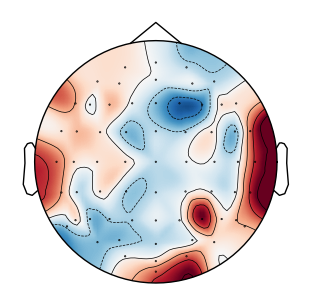

(<matplotlib.image.AxesImage at 0x26ffb9851f0>,
 <matplotlib.contour.QuadContourSet at 0x26ffb985550>)

In [12]:
#Single trial TESTING
single_complexity = LZc(data[0,:,0:64])
print(single_complexity)
per_channel_complexity = np.apply_along_axis(LZs, axis=1, arr=data[0,:,0:64])
print(np.mean(per_channel_complexity))
zscore_matrix = zscore(per_channel_complexity, axis=None)
mne.viz.plot_topomap(zscore_matrix, epocharray.info, size = 3)

In [9]:
#Lempel Ziv Complexity testing...

import numpy as np

single_trial_data = data[0,6,:]

binary_eeg = np.zeros(166)
median_value = np.median(single_trial_data)
for i in range(166):
    binary_eeg[i] = (single_trial_data[i] > median_value).astype(int)


# Set the window size
window_size = 1

# Binarize the EEG data

print(binary_eeg)

# Now you can proceed to calculate the Lempel-Ziv complexity for binarized_eeg as before

def lempel_ziv_complexity(sequence):
    """Compute the Lempel-Ziv complexity of a binary sequence."""
    i, k, l = 0, 1, 1
    complexity = 1
    n = len(sequence)
    while True:
        if sequence[i + l - 1] == sequence[k + l - 1]:
            l += 1
            if k + l > n:
                complexity += 1
                break
        else:
            if l == 1:
                complexity += 1
                i = k
            k += 1
            l = 1
            if k == n:
                break
    return complexity

# Example usage

lz_complexity = lempel_ziv_complexity(binary_eeg)
print("Lempel-Ziv Complexity:", lz_complexity)


[1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Lempel-Ziv Complexity: 53


In [14]:
#single channel testing, single timeseries
channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',
	'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1',
	'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz',
	'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4',
	'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4',
	'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8',
	'P10', 'PO8', 'PO4', 'O2']

x1 = data[0,channels.index('PO7'),:]
x2 = data[0,channels.index('Fp1'),:]

LZC_x1 = LZs(x1)
print("LZC of electode 1: " + str(LZC_x1))
LZC_x2 = LZs(x2)
print("LZC of electode 2: " + str(LZC_x2))

def stringthathoe(x):
 
 '''
 get the string to use
 '''
 
 co=len(x)
 x=signal.detrend((x-mean(x))/std(x), axis=0)
 s=''
 r=abs(hilbert(x))
 th=mean(r)
 
 for j in range(co):
  if r[j]>th:
   s+='1'
  else:
   s+='0'
 return s

print(ant.lziv_complexity(stringthathoe(x1),normalize = True))
print(ant.lziv_complexity(stringthathoe(x2),normalize = True))

LZC of electode 1: 0.72
LZC of electode 2: 0.94
0.4887074321976878
1.0662707611585915


In [15]:

#Single channel TESTING
channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',
	'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1',
	'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz',
	'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4',
	'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4',
	'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8',
	'P10', 'PO8', 'PO4', 'O2']


x1 = data[0,channels.index('PO7'),:]
x2 = data[0,channels.index('Fp1'),:]

LZC_x1 = LZs(x1)
print("LZC of electode 1: " + str(LZC_x1))
LZC_x2 = LZs(x2)
print("LZC of electode 2: " + str(LZC_x2))

print()
print("Antropy SampEn of electode 1: " + str(ant.sample_entropy(x1)))
print("Antropy SampEn of electode 2: " + str(ant.sample_entropy(x2)))

print()
std_x1 = np.std(x1)
std_x2 = np.std(x2)
print("PyEntrp SampEn of electode 1: " + str(ent.sample_entropy(x1,2,0.1*std_x1)))
print("PyEntrp SampEn of electode 2: " + str(ent.sample_entropy(x2,2,0.1*std_x2)))

print()
#sine
def sine_func(fs, freq, amp, time):
    samples = fs*time
    time = np.arange(samples)
    voltage = amp * np.sin(2 * np.pi * freq * time / fs)
    
    return time, voltage

fs = 128 # sampling rate
duration = 166/128 # in seconds

freq, amp = 10, 7 # in arbitrary units (au)
_, sine = sine_func(fs, freq, amp, duration)

print(stringthathoe(sine))

print("LZC of sine wave: " + str(LZs(sine)))
print("Antropy SampEn of sine wave: " + str(ant.sample_entropy(sine)))
print("Antropy LZC of sine wave: " + str(ant.lziv_complexity(stringthathoe(sine),normalize = True)))
print()
zero = np.zeros(166)
zero[0] = 1
zero[50] = 1
print("LZC of zeros: " + str(LZs(zero)))
print("Antropy SampEn of zeros: " + str(ant.sample_entropy(zero)))
print()

freq, amp, = 28, 3
_, sine = sine + sine_func(fs, freq, amp, duration)

print(stringthathoe(sine))
print("Antropy SampEn of more complicated sine: " + str(ant.sample_entropy(sine)))

LZC of electode 1: 0.7346938775510204
LZC of electode 2: 0.94

Antropy SampEn of electode 1: 1.453277181678818
Antropy SampEn of electode 2: 1.7519712191696422

PyEntrp SampEn of electode 1: [2.75744296 2.14237031]
PyEntrp SampEn of electode 2: [2.92900557 2.51824307]

0000011111110000000111111100000001111111000000111111100000001111111000000111111100000001111111000000111111110000001111111000000011111110000001111111000000011111110000
LZC of sine wave: 0.7450980392156863
Antropy SampEn of sine wave: 0.23169583312952693
Antropy LZC of sine wave: 0.3109956386712559

LZC of zeros: 0.7894736842105263
Antropy SampEn of zeros: 0.012499186239876904

0100001111000111000011110001111000111100011110001111000011100001110000111100011110001111000111100011110001111000111100011110000111100011100001111000111100011110001110
Antropy SampEn of more complicated sine: 0.6863674935745665


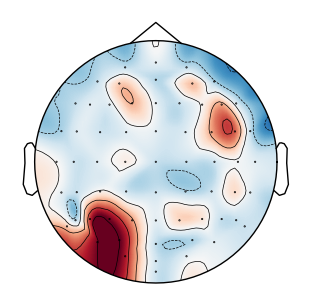

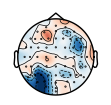

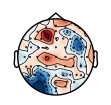

(<matplotlib.image.AxesImage at 0x26ffba16610>,
 <matplotlib.contour.QuadContourSet at 0x26ffba16490>)

In [16]:
per_channel_complexity1 = np.apply_along_axis(LZs, axis=1, arr=data[0,:,:])
per_channel_complexity2 = np.apply_along_axis(LZs, axis=1, arr=data[1,:,:])
abs_diff = np.abs(per_channel_complexity1 - per_channel_complexity2)
zscore_matrix = zscore(abs_diff, axis=None)
mne.viz.plot_topomap(zscore_matrix, epocharray.info, size = 3)


#testing zscores and what not
diff = per_channel_complexity1 - per_channel_complexity2
zscore_matrix = zscore(diff, axis=None)
mne.viz.plot_topomap(diff, epocharray.info)

diff = zscore(per_channel_complexity1, axis=None) - zscore(per_channel_complexity2, axis=None)
mne.viz.plot_topomap(diff, epocharray.info)

In [ ]:

#complexity_array = np.array([LZc(data[trial, :, :]) for trial in range(data.shape[0])]) #shape (n_trials X 1)-- complexity per trial
#np.save(r'C:\Users\jaket\COGS280\DataDeco\LZc_complexity_array.npy', complexity_array)                              

In [ ]:
#complexity_bychannel_array = np.array([np.apply_along_axis(LZs, axis=1, arr=data[trial,:,:] for trial in range(data.shape[0])]) #shape (n_trials X 64 channels)-- channel complexities per trial
#np.save(r'C:\Users\jaket\COGS280\DataDeco\LZs_complexity_bychannel_array.npy', complexity_bychannel_array)  


In [165]:
number_trials = len(data[:,-1,-1])
sampEn_bychannel_array = np.array([np.apply_along_axis(ant.sample_entropy, axis=1, arr=data[trial,:,:]) for trial in range(number_trials)]) #shape (n_trials X 64 channels)-- channel complexities per trial
np.save(r'C:\Users\jaket\COGS280\DataDeco\sampEn_bychannel_array.npy', sampEn_bychannel_array)

In [4]:
number_trials = len(data[:,-1,-1])
sampEn_bychannel_array = np.array([np.apply_along_axis(ant.sample_entropy, axis=1, arr=data[trial,:,0:64]) for trial in range(number_trials)]) #shape (n_trials X 64 channels)-- channel complexities per trial
np.save(r'C:\Users\jaket\COGS280\DataDeco\prestimulus_sampEn_bychannel_array.npy', sampEn_bychannel_array)

In [ ]:

#complexity_array = np.load(r'C:\Users\jaket\COGS280\DataDeco\complexity_array.npy')
#behavior['complexity'] = complexity_array
#complexity_bychannel_array = np.load(r'C:\Users\jaket\COGS280\DataDeco\complexity_bychannel_array.npy')
#list1 = [complexity_bychannel_array[i] for i in range(complexity_bychannel_array.shape[0])]
#behavior['complexity_bychannel'] = list1

In [17]:
sampEn_bychannel_array = np.load(r'C:\Users\jaket\COGS280\DataDeco\sampEn_bychannel_array.npy')
list1 = [sampEn_bychannel_array[i] for i in range(sampEn_bychannel_array.shape[0])]
behavior['sampEn_bychannel'] = list1
behavior['sampEn_mean'] = behavior['sampEn_bychannel'].apply(lambda x: np.mean(x))

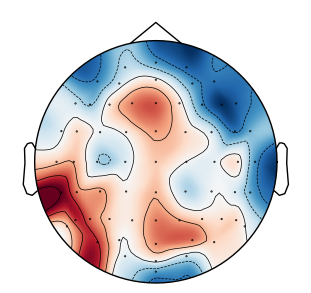

(<matplotlib.image.AxesImage at 0x26ffabbd160>,
 <matplotlib.contour.QuadContourSet at 0x26ffabbd4c0>)

In [19]:
correct_df = behavior[(behavior['correct'] == 1)]
incorrect_df = behavior[(behavior['correct'] == 0)]

correct_mean = np.mean(correct_df['sampEn_bychannel'])
incorrect_mean = np.mean(incorrect_df['sampEn_bychannel'])

diff = correct_mean-incorrect_mean

zscore_matrix = zscore(diff, axis=None)

mne.viz.plot_topomap(zscore_matrix, epocharray.info, size = 3)


1.6800098136312693
1.6590316263652582
Statistic: 188406849.0, P-value: 3.5960525643914453e-20


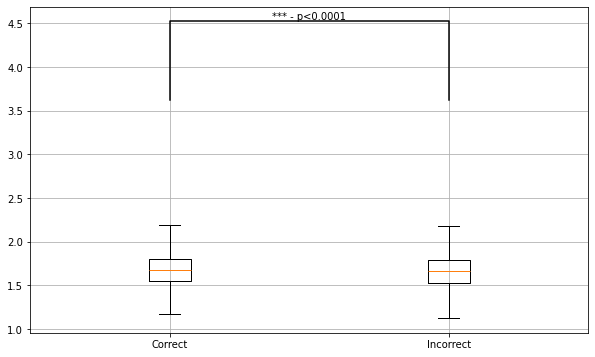

In [174]:
correct_df = behavior[(behavior['correct'] == 1)]
incorrect_df = behavior[(behavior['correct'] == 0)]

correct_mean = correct_df['sampEn_mean']
incorrect_mean = incorrect_df['sampEn_mean']

print(np.mean(correct_mean))
print(np.mean(incorrect_mean))

# Creating the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(x = [correct_mean, incorrect_mean], positions=[1, 2], showfliers= False)
plt.xticks([1, 2], ['Correct', 'Incorrect'])
plt.grid(True)

from scipy.stats import mannwhitneyu

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(correct_mean, incorrect_mean, alternative='two-sided')

print(f'Statistic: {stat}, P-value: {p_value}')

Q3_group1 = np.percentile(correct_mean, 75)
Q3_group2 = np.percentile(incorrect_mean, 75)

# Find the maximum Q3 value
max_Q3 = max(Q3_group1, Q3_group2)

y, h, col = max_Q3, max_Q3, 'k'  # y: start height, h: height of the line, col: color
plt.plot([1, 1, 2, 2], [y+h, y+h+(0.5*h), y+h+(0.5*h), y+h], lw=1.5, c=col)


if p_value < 0.0001:
    sig_text = '*** - p<0.0001'
elif p_value < 0.01:
    sig_text = '** - p<0.01'
elif p_value < 0.05:
    sig_text = '*'
else:
    sig_text = 'n.s.'  # not significant
plt.text(1.5, y+h+(0.5*h), sig_text, ha='center', va='bottom', color=col)

plt.show()

In [136]:
import numpy as np
from scipy.signal import detrend, butter, lfilter
from numpy.fft import fft
from numpy.random import shuffle
from scipy.signal import hilbert

def cpr(string):
    '''
    Lempel-Ziv-Welch compression of binary input string, e.g. string='0010101'.
    It outputs the size of the dictionary of binary words.
    '''
    d = {}
    w = ''
    for c in string:
        wc = w + c
        if wc in d:
            w = wc
        else:
            d[wc] = wc
            w = c
    return len(d)

def LZs(x):
    '''
    Compute Lempel-Ziv complexity of a single timeseries without Hilbert transform.
    '''
    # Normalize and detrend the signal
    x = detrend((x - np.mean(x)) / np.std(x), axis=0)

    # Binarize the signal based on the mean
    # Since the signal is normalized, values above 0 are '1's and below are '0's
    s = ''.join(['1' if val > 0 else '0' for val in x])

    # Calculate complexity of the original sequence
    complexity_original = cpr(s)

    # Shuffle the sequence to calculate complexity of a randomized version
    # Note: You might want to skip shuffling for a more consistent normalization approach
    M = list(s)
    shuffle(M)
    shuffled_s = ''.join(M)
    complexity_shuffled = cpr(shuffled_s)

    # Normalize the complexity by comparing to the shuffled version
    # Or consider a different normalization approach as needed
    normalized_complexity = complexity_original / float(complexity_shuffled)

    return normalized_complexity

# Example data - a sine wave
fs = 1000  # Sampling frequency
T = 1 / fs  # Sampling interval
t = np.arange(0, 1, T)  # Time vector
freq = 5  # Frequency of the sine wave
x = np.sin(2 * np.pi * freq * t)  # Sine wave

# Compute LZ complexity
lzc = LZs(x)
print("Normalized LZC of the sine wave: ", lzc)

print(LZs(x1))
print(LZs(x2))


Normalized LZC of the sine wave:  0.3553299492385787
0.8775510204081632
0.88
